# EXPORT SHARES: UKRAINIAN AGRICULTURAL EXPORTS

Name: Josemaria Macedo Carrillo\
Created: 08/07/23\
Last modified: 01/18/24\
DSI

The purpose of this notebook is to analyze data on Ukrainian agricultural
exports for October 2022 (busiest month according to BSGI). The main data sources
are the Black Sea Grain Initiative (BSGI) of the United
Nations and Import Genius (IG), a website that has trade data for different countries
including Ukraine.

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from utils.plot import cargo_grouping, plot_pie, plot_stack_bar
from utils.clean_data import translate_column
from utils.transform_data import create_wide_table
import os
from config import CLEAN_FILES

FileNotFoundError: [Errno 2] No such file or directory: 'names.json'

## HELPER FUNCTIONS

In [31]:
def manually_add_subsidiaries(original_dict, manual_dict):
    """
    Add subsidaries manually as values to company dictionary.

    Inputs:
        manual_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        source_lan (str): current language code of values of dictionary
        target_lan (str): target language code we want to translate values to


    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    for parent, subsidiary_lst in manual_dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()
        if parent in original_dict:
            original_dict[parent] += manual_dict[parent]
        else:
            original_dict[parent] = manual_dict[parent]

    return original_dict

def estimate_table_percentages(table):
    """
    Add non-repeated values from 'new_dict' to 'old_dict' based on keys.

    Inputs:
        old_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        new_dict (dict): dictionary with parent companies as keys and new
            subsidaries as values.

    Returns (dict): None. The function does the change in place of the input
        'old_dict'.
    """
    table = table.fillna(0)
    date = table["date"]
    percentage_df = table.drop(columns=["date"]).divide(table.drop(columns=\
                                            ["date"]).sum(axis=1), axis=0) * 100
    percentage_df = percentage_df.round(2)
    percentage_df["date"] = date
    
    return percentage_df

def plot_multiple_countries(country_dict, data, y_axis_limit, source):
    """
    Plot stacked bar charts for more than one country

    Inputs:
        country_dict (dict): dictionary with country names in BSGI as keys
            (in English) and country names in IG as values (Ukrainian)
        data (DataFrame): dataset with information to plot
        y_axis_limit (int): y axis limit in scale
        source (str): text to say which is the data source for the plot.

    Returns (dict): None. The function plots the stacked bar charts.
    """
    for country_en, country_uk in country_dict.items():
        ig_country = data[data["country"] == country_uk]
        pivot_country = create_wide_table(ig_country,
                                          ["year", "month", "company_std"],
                                          ["weight_ton"],
                                          ["year", "month", "company_std"], True,
                                          {"weight_ton": "sum"})
        plot_stack_bar(pivot_country, "Total exports by company",
                       "Weight of exports (metric tons)",
                       f"Total exports to {country_en.capitalize()} by company",
                       "date", y_axis_limit, source)

def plot_all_period(data, source, min_wedge_percentage=2,
                    min_legend_percentage=0):
    """
    Plot a pie chart to estimate the export shares for the whole period of time
        (August 2022 until March 2023), not by month.

    Inputs:
        data (DataFrame): dataset with information to plot
        source (str): text to say which is the data source for the plot
        min_wedge_percentage (float, optional): minimum percentage threshold for
            annotating wedges (default is 2)
        min_legend_percentage (float, optional): minimum percentage threshold
            for adding wedges legend (default is 0).

    Returns (DataFrame): table used to plot pie chart.
    """
    whole_period_g = cargo_grouping(data, ["company_std"], ["weight_ton"],
                                    ["weight_ton"], False, {"weight_ton": "sum"})
    whole_period_g = whole_period_g.reset_index(drop=True)
    plot_pie(whole_period_g["company_std"], whole_period_g["weight_ton"],
             "Company category",
             "Share of exports (metric tons) exported by company", source,
             min_wedge_percentage, min_legend_percentage)
    
    return whole_period_g

def plot_pc_monthly(df, group, agg_cols, sort, asc_bool, agg_dict, x_title,
                    y_title, plot_title, x_axis_ticks, data_source):
    """
    Plot a pie chart to estimate the export shares for the whole period of time
        (August 2022 until March 2023) by month for one country.

    Inputs:
        df (DataFrame): dataset to be used
        group (lst): list of columns to group by
        other_cols(lst): list of columns that are going to be aggregated
        sort (lst): list of columns to sort dataframe by. If new_name is not
            empty then the new column names should be used
        asc_bool (bool): boolean stating wheter or not to sort data "ascending"
            (True) or "descending" (False)
        agg_dict (dict): dict with aggregation functions we want to apply to
            data. If we want to aggregate a column by more than one function
            we put the functions as a list. Example: {"var": ["count", "sum"]}.
        x_title (str): horizontal axis title
        y_title (str): horizontal axis title
        plot_title (str): plot title
        x_axis_ticks (str): name of column to use for x axis tick names
        data_source (str): data source text.

    Return: None. Function plots pie chart.
    """
    pivot = create_wide_table(df=df, group=group, agg_cols=agg_cols, sort=sort,
                              asc_bool=asc_bool, agg_dict=agg_dict, new_name=None)

    percentages_df = estimate_table_percentages(pivot)

    plot_stack_bar(df=percentages_df, x_title=x_title, y_title=y_title,
                plot_title=plot_title, x_ticks=x_axis_ticks, ylim=105,
                data_source=data_source)

def export_csv(df, file_name):
    """
    Export dataframe as .cvs file with a specific file name.

    Inputs:
        df (Dataframe): Import Genius clean and transformed data
        file_name (string): file name for .csv file we want to export

    Return: None. Exports .csv file in "/data" directory
    """
    df_filtered = df[["shipper", "company_std", "weight_ton"]]

    translate_column(df_filtered, "shipper", "google", source="uk", target="en")

    df_filtered = df_filtered.rename(columns={"shipper": "subsidiary",
                                              "company_std": "parent_company",
                                              "weight_ton": "weight_ton_subs",
                                              "shipper_gt": "subsidiary_en"})\
    [["subsidiary", "subsidiary_en", "parent_company", "weight_ton_subs"]].\
        sort_values(by = "weight_ton_subs", ascending=False)
    
    df_g = df_filtered.groupby(["subsidiary", "subsidiary_en", "parent_company"],
                               as_index=False).sum("weight_ton_subs").\
                                sort_values(by=["weight_ton_subs"],
                                            ascending=False)
    
    path = os.path.join("../data", file_name)
    df_g.to_csv(path, index=False)

## TOTAL EXPORTS BY COMPANY

### PIE CHART FOR WHOLE PERIOD (August 2022 -  March 2023)

We get the data from Import Genius (IG) and Black Sea Grain Initiative (BSGI) for some countries ("asia" or "spain").

In [4]:
country = "belgium"
path = CLEAN_FILES[country]
ig = pd.read_csv(path)

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_58438/3958975430.py:291: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")
/Users/jmacedoc/Documents/DSI/Ukraine-Agricultural-Exports/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str.lower().str.contains(company, na=False)
/Users/jmacedoc/Documents/DSI/Ukraine-Agricultural-Exports/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str.lower().str.contains(company, na=False)
/Users/jmacedoc/Documents/DSI/Ukraine-Agricultural

Plot export shares for the whole period (August 2022 until March 2023)

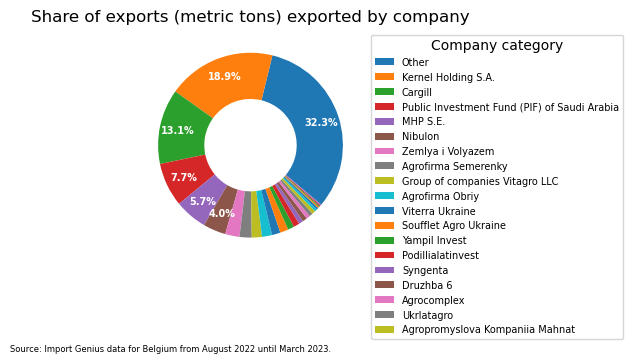

,company_std,weight_ton
0,Other,149740.43372
1,Kernel Holding S.A.,87833.35436
2,Cargill,60909.32300
3,Public Investment Fund (PIF) of Saudi Arabia,35593.26400
4,MHP S.E.,26338.65000
5,Nibulon,18411.37500
6,Zemlya i Volyazem,11583.54600
7,Agrofirma Semerenky,9847.40000
8,Group of companies Vitagro LLC,8263.31000
9,Agrofirma Obriy,8147.78400


In [5]:
# TODO: Use keyword arguments if it's not obvious what something is - 2, .5 for example
data_source = "Import Genius data for Belgium from August 2022 until March 2023"

export_shares_all = plot_all_period(ig, data_source, min_wedge_percentage=3, min_legend_percentage=.5)
export_shares_all

We plot exports now by month.

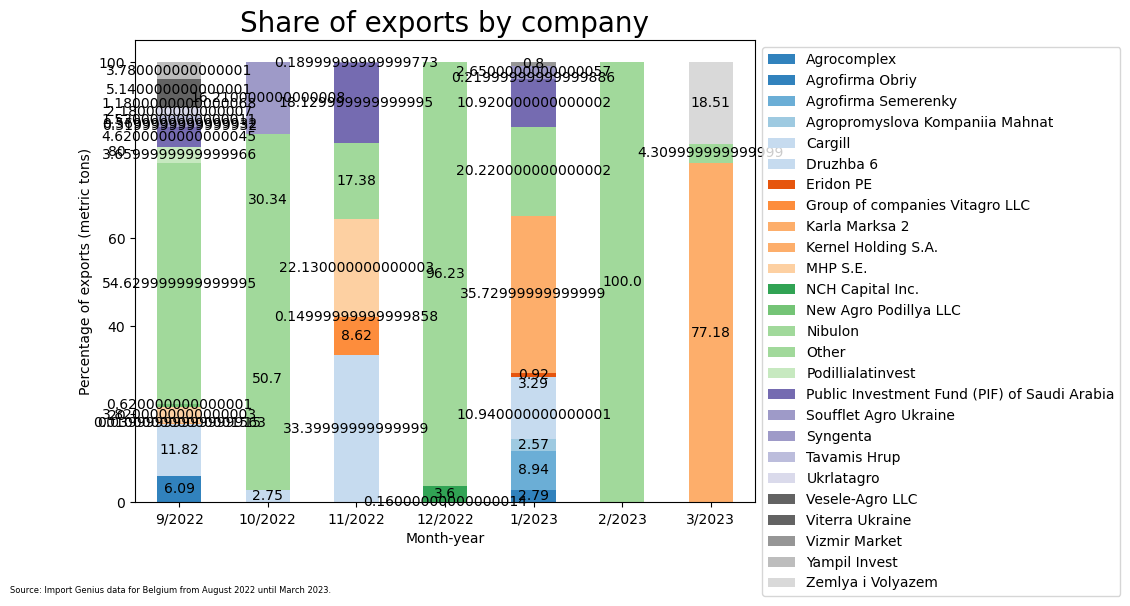

In [6]:
grouping_cols = ["year", "month", "company_std"]
other_cols = ["weight_ton"]
sort_by = ["year", "month", "company_std"]
aggregate_by = {"weight_ton": "sum"}
x_title = "Month-year"
y_title = "Percentage of exports (metric tons)"
plot_title = "Share of exports by company"
x_axis_ticks = "date"


plot_pc_monthly(df=ig, group=grouping_cols, agg_cols=other_cols,
                sort=sort_by, asc_bool=True, agg_dict=aggregate_by,
                x_title=x_title, y_title=y_title, plot_title=plot_title,
                x_axis_ticks=x_axis_ticks, data_source=data_source)

## TABLE WITH EXPORTS BY COMPANY (ALL COMPANIES INCLUDED)

In [33]:
export_csv(ig, "total_exports_by_company_belgium_test.csv")

/Users/jmacedoc/Documents/DSI/Ukraine-Agricultural-Exports/oakland-institute-ukraine/notebooks/../utils/clean_data.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column.lower() + "_gt"] = df[column].apply(lambda x: d[x])


We only keep the columns that we care about which are the subsidiary name, parent company name and weight of exported commodities by the subsidiary.

## EXPLORATORY ANALYSIS FOR MANUAL COMPANY MATCHING

We first get the top n companies exporting to Ukraine.

In [13]:
tempo = cargo_grouping(ig, ["company_all"], ["weight_ton"], ["weight_ton"], True, {"weight_ton": "sum"})
tempo.sort_values(by=["weight_ton"], ascending=False)[:50]

,company_all,weight_ton
9,Kernel Holding S.A.,87833.35436
4,Cargill,60909.32300
15,Public Investment Fund (PIF) of Saudi Arabia,35593.26400
10,MHP S.E.,26338.65000
13,Nibulon,18411.37500
24,Zemlya i Volyazem,11583.54600
2,Agrofirma Semerenky,9847.40000
7,Group of companies Vitagro LLC,8263.31000
1,Agrofirma Obriy,8147.78400
21,Viterra Ukraine,6874.45000


Then we get the full company name.

In [14]:
tempo.loc[82]["company_all"]

'ТОВ АГРОФІРМА РУБАНСЬКИЙ УКРАЇНА 23400 ВІННИЦЬКА ОБЛ МОГИЛІВ ПОДІЛЬСЬКИЙ Р Н СМТ МУРОВАНІ'

We double check that the company is actually exporting crops to confirm we filtered the IG dataset correctly with companies that only export agricultural products that appear in BSGI.

In [15]:
ig[ig["shipper"] == 'ТОВ ЗЕМЛЯ І ВОЛЯ 17400 ЧЕРНІГІВСЬКА ОБЛ М БОБРОВИЦЯ ВУЛ ЧЕРНІГІВСЬКА 34']["product"]

1332    кукурудза: - інша
Name: product, dtype: object

We check if there are any name matches with the Land Matrix company parents we found
in Land Matrix.

First we get the Land Matrix data.

In [16]:
deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")
deals_c = deals.copy()
deals_c.loc[:, "country_low"] = deals_c.loc[:, "Target country"].str.lower()
deals_c = deals_c.loc[deals_c.loc[:, "country_low"].str.contains("ukraine", na=False)]
deals_c["Target country"]

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_58438/99570549.py:1: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")


572     Ukraine
573     Ukraine
574     Ukraine
575     Ukraine
576     Ukraine
         ...   
6461    Ukraine
6462    Ukraine
6463    Ukraine
6464    Ukraine
6467    Ukraine
Name: Target country, Length: 358, dtype: object

Then we look for companies matches manually in Land Matrix data.

In [17]:
deals_c[deals_c["Top parent companies"].str.lower().str.contains("vol")]["Top parent companies"]

2425                          Volynzernoproduct LLC#5023#
3659    Alberto Kazoni#5062#|Kyrylenko Volodymyr#5063#...
4707    Johann Yager Jacob#41994#|Venhri Agrar#41995#|...
5527                          Volodarsk Inagro LLC#43420#
6163    Chuikevych Volodymyr#44276#|Karbovnichyi Andri...
Name: Top parent companies, dtype: object

In [18]:
sorted(deals_c["Top parent companies"].unique())

['AGR Invest Holding Ltd#40757#',
 'AGT Capital Management Ltd.#41248#',
 'Agro Ukraina AB#44407#',
 'Agro-Podillya i K LLC#43419#',
 'AgroGeneration#656#',
 'AgroGeneration#656#|Azent Ltd.#40783#',
 'AgroGeneration#656#|L`ost Dominic#41121#|Mandua Catrin#41123#|Claud Mandua#41124#',
 'Agromino A/S#4970#',
 'Agroton Public Limited#38647#',
 'Agrovista Limited#41491#',
 'Akella Impex LP#5042#',
 'Aladin tekstil ve hiyim iuriunleri tidzharet LLC#44904#',
 'Alberto Kazoni#5062#|Kyrylenko Volodymyr#5063#|Vorotyntsev Vitaliy#5064#',
 'Albus Gunter#41907#',
 'Alexander Wolters#41898#',
 'Alpha-Capital LLC#44409#',
 'Aslan Global Management#1779#',
 'BKW Group LLC#43027#',
 'Berend Popke van der Velde#40762#|Herrit Tonkens#40763#|Huzinha Kornelius Hendrick#40764#|Oxana Kryachko#40765#',
 'Berry Farma ApS#5060#',
 'Bitex Trade Ltd.#43046#',
 'Bontrup Holding#4963#',
 'Brunner&Partner LLC#5047#|Glendore Holding LLC#5048#',
 "Brykivs'ke LLC#43422#",
 'CNBM International energy PTE.LTD#44677#',
 